<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session_10/ViT_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision

In [2]:
DATA_DIR='./data'

In [3]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


### ViT

In [4]:
patch_size = 8 # P

In [5]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=8,
                 embedding_dim:int=256):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [6]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=256, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=8, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [7]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=256, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=512, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [8]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=256, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=8, # Heads from Table 1 for ViT-Base
                 mlp_size:int=512, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [9]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=32, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=8, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=256, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=512, # MLP size from Table 1 for ViT-Base
                 num_heads:int=8, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=10): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [10]:
NUM_CLASSES, IMAGE_SIZE = 10, 32
model = ViT(num_classes=10)

In [11]:
model.to(DEVICE)

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 256, kernel_size=(8, 8), stride=(8, 8))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiheadSelfAttentionBlock(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=256, out_features=512, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=512, out_features=256, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1):

In [12]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,382,346


### Model summary

In [13]:
!pip install -q torchinfo

In [14]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                            Param #
ViT                                                               4,608
├─Dropout: 1-1                                                    --
├─PatchEmbedding: 1-2                                             --
│    └─Conv2d: 2-1                                                49,408
│    └─Flatten: 2-2                                               --
├─Sequential: 1-3                                                 --
│    └─TransformerEncoderBlock: 2-3                               --
│    │    └─MultiheadSelfAttentionBlock: 3-1                      263,680
│    │    └─MLPBlock: 3-2                                         263,424
│    └─TransformerEncoderBlock: 2-4                               --
│    │    └─MultiheadSelfAttentionBlock: 3-3                      263,680
│    │    └─MLPBlock: 3-4                                         263,424
│    └─TransformerEncoderBlock: 2-5                               --
│ 

In [15]:
IMAGE_SIZE = 32

NUM_CLASSES = 10
NUM_WORKERS = 8
BATCH_SIZE = 128
EPOCHS = 25 #25

LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1

cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=1, magnitude=8),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=0.25)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=4)


Files already downloaded and verified


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


In [16]:
import time


clip_norm = True
lr_schedule = lambda t: np.interp([t], [0, EPOCHS*2//5, EPOCHS*4//5, EPOCHS], 
                                  [0, 0.01, 0.01/20.0, 0])[0]

model = nn.DataParallel(model, device_ids=[0]).cuda()
opt = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

for epoch in range(EPOCHS):
    start = time.time()
    train_loss, train_acc, n = 0, 0, 0
    for i, (X, y) in enumerate(trainloader):
        model.train()
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(trainloader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            torch.cuda.empty_cache()

            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        if clip_norm:
            scaler.unscale_(opt)
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt)
        scaler.update()
        
        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)
        
    model.eval()
    test_acc, m = 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
            test_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)

    print(f'ConvMixer: Epoch: {epoch} | Train Acc: {train_acc/n:.4f}, Test Acc: {test_acc/m:.4f}, Time: {time.time() - start:.1f}, lr: {lr:.6f}')


ConvMixer: Epoch: 0 | Train Acc: 0.3120, Test Acc: 0.4203, Time: 98.9, lr: 0.001000
ConvMixer: Epoch: 1 | Train Acc: 0.3681, Test Acc: 0.3895, Time: 88.7, lr: 0.002000
ConvMixer: Epoch: 2 | Train Acc: 0.2971, Test Acc: 0.3180, Time: 89.1, lr: 0.003000
ConvMixer: Epoch: 3 | Train Acc: 0.2565, Test Acc: 0.2613, Time: 86.9, lr: 0.004000
ConvMixer: Epoch: 4 | Train Acc: 0.2344, Test Acc: 0.2567, Time: 87.7, lr: 0.005000
ConvMixer: Epoch: 5 | Train Acc: 0.2230, Test Acc: 0.2731, Time: 88.9, lr: 0.006000
ConvMixer: Epoch: 6 | Train Acc: 0.2304, Test Acc: 0.2388, Time: 85.5, lr: 0.007000
ConvMixer: Epoch: 7 | Train Acc: 0.2205, Test Acc: 0.2556, Time: 87.7, lr: 0.008000
ConvMixer: Epoch: 8 | Train Acc: 0.2173, Test Acc: 0.2393, Time: 87.2, lr: 0.009000
ConvMixer: Epoch: 9 | Train Acc: 0.2146, Test Acc: 0.2472, Time: 89.6, lr: 0.010000
ConvMixer: Epoch: 10 | Train Acc: 0.2208, Test Acc: 0.2562, Time: 86.5, lr: 0.009050
ConvMixer: Epoch: 11 | Train Acc: 0.2321, Test Acc: 0.2697, Time: 88.1, lr:

### gradcam on 10 Misclassified images

In [17]:
!pip3 install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
print([n for n, _ in model.module.classifier.named_children()])

['0', '1']


In [19]:
import random

In [20]:
target_layers_name = [name for name, module in model.named_modules() if isinstance(module, nn.GELU)]

In [21]:
print (target_layers_name)

['module.transformer_encoder.0.mlp_block.mlp.1', 'module.transformer_encoder.1.mlp_block.mlp.1', 'module.transformer_encoder.2.mlp_block.mlp.1', 'module.transformer_encoder.3.mlp_block.mlp.1', 'module.transformer_encoder.4.mlp_block.mlp.1', 'module.transformer_encoder.5.mlp_block.mlp.1', 'module.transformer_encoder.6.mlp_block.mlp.1', 'module.transformer_encoder.7.mlp_block.mlp.1', 'module.transformer_encoder.8.mlp_block.mlp.1', 'module.transformer_encoder.9.mlp_block.mlp.1', 'module.transformer_encoder.10.mlp_block.mlp.1', 'module.transformer_encoder.11.mlp_block.mlp.1']


In [22]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

In [23]:
def wrong_predictions(model, test_loader, device):
    wrong_images=[]
    wrong_label=[]
    correct_label=[]
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)        
            pred = output.argmax(dim=1, keepdim=True).squeeze()  # get the index of the max log-probability

            wrong_pred = (pred.eq(target.view_as(pred)) == False)
            wrong_images.append(data[wrong_pred])
            wrong_label.append(pred[wrong_pred])
            correct_label.append(target.view_as(pred)[wrong_pred])
            wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))
        print(f'Total wrong predictions are {len(wrong_predictions)}')

    return wrong_predictions

In [24]:
from torch.nn import functional as F
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np


class GradCAM:
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers 
    target_layers = list of convolution layer index as shown in summary
    """
    def __init__(self, model, candidate_layers=None):
        def save_fmaps(key):
            def forward_hook(module, input, output):
                self.fmap_pool[key] = output.detach()

            return forward_hook

        def save_grads(key):
            def backward_hook(module, grad_in, grad_out):
                self.grad_pool[key] = grad_out[0].detach()

            return backward_hook

        self.device = next(model.parameters()).device
        self.model = model
        self.handlers = []  # a set of hook function handlers
        self.fmap_pool = {}
        self.grad_pool = {}
        self.candidate_layers = candidate_layers  # list

        for name, module in self.model.named_modules():
            if self.candidate_layers is None or name in self.candidate_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def _encode_one_hot(self, ids):
        one_hot = torch.zeros_like(self.nll).to(self.device)
        #print(one_hot.shape)
        one_hot.scatter_(1, ids, 1.0)
        return one_hot

    def forward(self, image):
        self.image_shape = image.shape[2:] # HxW
        self.nll = self.model(image)
        #self.probs = F.softmax(self.logits, dim=1)
        return self.nll.sort(dim=1, descending=True)  # ordered results

    def backward(self, ids):
        """
        Class-specific backpropagation
        """
        one_hot = self._encode_one_hot(ids)
        self.model.zero_grad()
        self.nll.backward(gradient=one_hot, retain_graph=True)

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def _find(self, pool, target_layer):
        if target_layer in pool.keys():
            return pool[target_layer]
        else:
            raise ValueError("Invalid layer name: {}".format(target_layer))

    def generate(self, target_layer):
        fmaps = self._find(self.fmap_pool, target_layer)
        grads = self._find(self.grad_pool, target_layer)
        weights = F.adaptive_avg_pool2d(grads, 1)
        gcam = torch.mul(fmaps, weights).sum(dim=1, keepdim=True)
        gcam = F.relu(gcam)
        # need to capture image size during forward pass
        gcam = gcam[:, :, :].reshape(gcam.size(0),gcam.size(1), 16, 16)
        # Bring the channels to the first dimension,
        # like in CNNs.
        #print (self.image_shape, gcam.shape)
        gcam = F.interpolate(
            gcam, self.image_shape, mode="bilinear", align_corners=True
        )

        # scale output between 0,1
        B, C, H, W = gcam.shape
        gcam = gcam.view(B, -1)
        gcam -= gcam.min(dim=1, keepdim=True)[0]
        gcam /= gcam.max(dim=1, keepdim=True)[0]
        gcam = gcam.view(B, C, H, W)

        return gcam

def generate_gradcam(misclassified_images, model, target_layers, device):
    images=[]
    labels=[]
    for i, (img, pred, correct) in enumerate(misclassified_images):
        images.append(img)
        labels.append(correct)
    
    model.eval()
    
    # map input to device
    images = torch.stack(images).to(device)
 
    
    # set up grad cam
    gcam = GradCAM(model, target_layers)
    
    # forward pass
    probs, ids = gcam.forward(images)

    # outputs agaist which to compute gradients
    ids_ = torch.LongTensor(labels).view(len(images),-1).to(device)
    
    # backward pass
    gcam.backward(ids=ids_)
    layers = []
    for i in range(len(target_layers)):
        target_layer = target_layers[i]
        print("Generating Grad-CAM @{}".format(target_layer))
        # Grad-CAM
        layers.append(gcam.generate(target_layer=target_layer))
        #print ("here4")
        
    # remove hooks when done
    gcam.remove_hook()
    return layers, probs, ids

def plot_gradcam(gcam_layers, target_layers, class_names, image_size, predicted, misclassified_images, mean, std):
    
    images=[]
    labels=[]
    for i, (img, pred, correct) in enumerate(misclassified_images):
        images.append(img)
        labels.append(correct)

    c = len(images)+1
    r = len(target_layers)+2
    fig = plt.figure(figsize=(30,14))
    fig.subplots_adjust(hspace=0.01, wspace=0.01)
    ax = plt.subplot(r, c, 1)
    ax.text(0.3,-0.5, "INPUT", fontsize=14)
    plt.axis('off')
    
    for i in range(len(target_layers)):
        target_layer = target_layers[i]
        ax = plt.subplot(r, c, c*(i+1)+1)
        ax.text(0.3,-0.5, target_layer, fontsize=14)
        plt.axis('off')

        for j in range(len(images)):
            #print("processing image " + str(j+1))
            img = np.uint8(255*unnormalize(images[j].view(image_size), mean, std))
            if i==0:
                ax = plt.subplot(r, c, j+2)
                ax.text(0, 0.2, f"actual: {class_names[labels[j]]} \npredicted: {class_names[predicted[j][0]]}", fontsize=12)
                plt.axis('off')
                plt.subplot(r, c, c+j+2)
                plt.imshow(img)
                plt.axis('off')
                
                heatmap = 1-gcam_layers[i][j].cpu().numpy()[0] # reverse the color map
                heatmap = np.uint8(255 * heatmap)
                heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
                superimposed_img = cv2.resize(cv2.addWeighted(img, 0.5, heatmap, 0.5, 0), (128,128))
                plt.subplot(r, c, (i+2)*c+j+2)
                plt.imshow(superimposed_img, interpolation='bilinear')
                plt.axis('off')
        
    plt.show()
    
def unnormalize(img, mean, std):
    img = img.cpu().numpy().astype(dtype=np.float32)
  
    for i in range(img.shape[0]):
        img[i] = (img[i]*std[i])+mean[i]
  
    return np.transpose(img, (1,2,0))

Total wrong predictions are 7094
Generating Grad-CAM @module.transformer_encoder.11


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


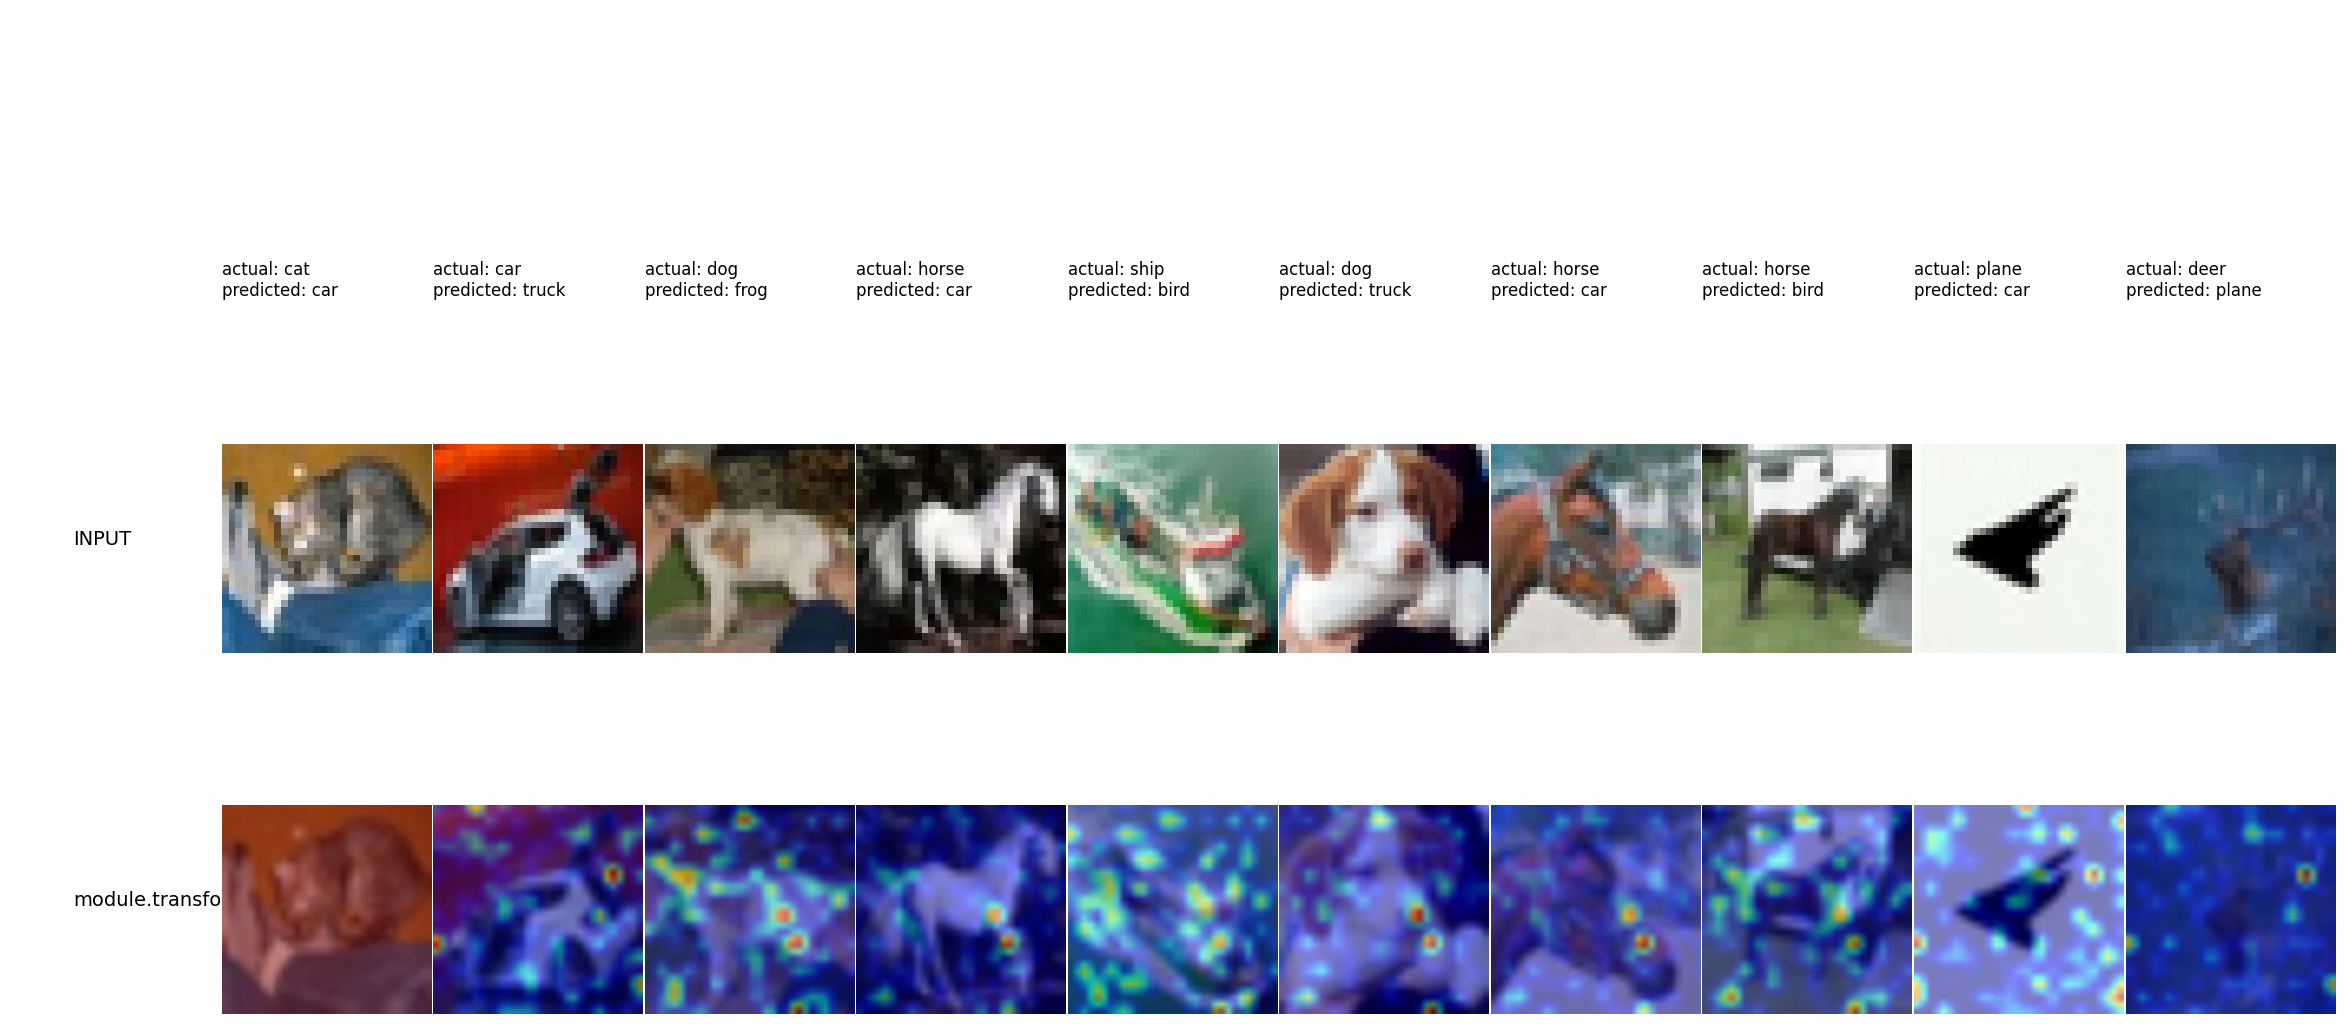

In [25]:
target_layers = ['module.transformer_encoder.11']
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
misclassified_images  = wrong_predictions(model, testloader, DEVICE)
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[:10], model, target_layers, DEVICE)
plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:10], mean, std)